In [9]:
#Import the necessary modules and libraries for the project
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time
import geopandas as gpd
from libpysal import weights
import momepy
import math



In [3]:
#import the data from the excel file 
df = pd.read_excel('road_network_info.xlsx')
df

,FID,Link_ID,Shape *,id,highway,start_x,end_x,start_y,end_y,Length,start_xy,end_xy,Start_node,End_node
0,0,1,Polyline,246115483,residential,444201,444076,1565732,1565611,174.195189,4442011565732,4440761565611,284,272
1,1,2,Polyline,5309249,service,445331,445197,1568639,1568646,134.623826,4453311568639,4451971568646,364,350
2,2,3,Polyline,5309445,service,444382,444698,1563465,1563391,324.748323,4443821563465,4446981563391,300,316
3,3,4,Polyline,5309941,service,443375,442992,1565987,1566002,383.083680,4433751565987,4429921566002,240,212
4,4,5,Polyline,5312662,living_street,444187,444766,1560893,1560714,629.169338,4441871560893,4447661560714,280,325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,580,581,Polyline,246250773,service,447326,447522,1569147,1569196,202.513348,4473261569147,4475221569196,421,424
581,581,582,Polyline,246251063,service,447667,447388,1568878,1567941,984.065756,4476671568878,4473881567941,425,423
582,582,583,Polyline,246251063,service,447388,447280,1567941,1568972,1155.337296,4473881567941,4472801568972,423,420
583,583,584,Polyline,246251063,service,447280,447667,1568972,1568878,402.781054,4472801568972,4476671568878,420,425


In [10]:
def progressive_widening_search(G, source, value, condition, initial_width=1):
    """Progressive widening beam search to find a node.

    The progressive widening beam search involves a repeated beam
    search, starting with a small beam width then extending to
    progressively larger beam widths if the target node is not
    found. This implementation simply returns the first node found that
    matches the termination condition.

    `G` is a NetworkX graph.

    `source` is a node in the graph. The search for the node of interest
    begins here and extends only to those nodes in the (weakly)
    connected component of this node.

    `value` is a function that returns a real number indicating how good
    a potential neighbor node is when deciding which neighbor nodes to
    enqueue in the breadth-first search. Only the best nodes within the
    current beam width will be enqueued at each step.

    `condition` is the termination condition for the search. This is a
    function that takes a node as input and return a Boolean indicating
    whether the node is the target. If no node matches the termination
    condition, this function raises :exc:`NodeNotFound`.

    `initial_width` is the starting beam width for the beam search (the
    default is one). If no node matching the `condition` is found with
    this beam width, the beam search is restarted from the `source` node
    with a beam width that is twice as large (so the beam width
    increases exponentially). The search terminates after the beam width
    exceeds the number of nodes in the graph.

    """
    # Check for the special case in which the source node satisfies the
    # termination condition.
    if condition(source):
        return source
    # The largest possible value of `i` in this range yields a width at
    # least the number of nodes in the graph, so the final invocation of
    # `bfs_beam_edges` is equivalent to a plain old breadth-first
    # search. Therefore, all nodes will eventually be visited.
    log_m = math.ceil(math.log2(len(G)))
    for i in range(log_m):
        width = initial_width * pow(2, i)
        # Since we are always starting from the same source node, this
        # search may visit the same nodes many times (depending on the
        # implementation of the `value` function).
        for u, v in nx.bfs_beam_edges(G, source, value, width):
            if condition(v):
                return v
    # At this point, since all nodes have been visited, we know that
    # none of the nodes satisfied the termination condition.
    raise nx.NodeNotFound("no node satisfied the termination condition")

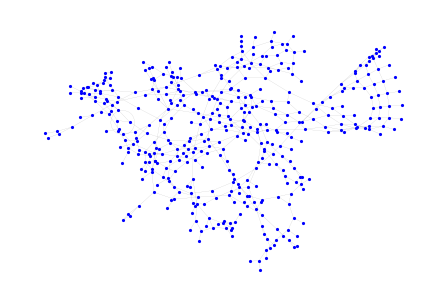

In [11]:
# Set a seed for random number generation so the example is reproducible
seed = 89
G = nx.from_pandas_edgelist(df, 'Start_node', 'End_node', create_using=nx.Graph())
#centrality = nx.eigenvector_centrality(G)
#avg_centrality = sum(centrality.values()) / len(G)


# Draw graph
pos = nx.spring_layout(G, seed=seed)
options = {
    "node_color": "blue",
    "node_size": 10,
    "edge_color": "grey",
    "linewidths": 0,
    "width": 0.1,
}
nx.draw(G, pos, **options)
# Draw node with high centrality as large and red
#nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_color="red", node_size=100)
plt.show()

In [4]:
#Updating the datafile to a Geopandas datafile using .shp for clear and concise visualization of the data
seaside = gpd.read_file('seaside_roads.shp')
seaside

,id,highway,start_x,end_x,start_y,end_y,Length,start_xy,end_xy,Start_node,End_node,Link_ID,geometry
0,246115483,residential,444201,444076,1565732,1565611,174.195189,4442011565732,4440761565611,284,272,1,"LINESTRING (444202.129 1565735.383, 444076.694..."
1,5309249,service,445331,445197,1568639,1568646,134.623826,4453311568639,4451971568646,364,350,2,"LINESTRING (445331.908 1568642.190, 445197.463..."
2,5309445,service,444382,444698,1563465,1563391,324.748323,4443821563465,4446981563391,300,316,3,"LINESTRING (444382.459 1563467.782, 444698.695..."
3,5309941,service,443375,442992,1565987,1566002,383.083680,4433751565987,4429921566002,240,212,4,"LINESTRING (443375.774 1565990.045, 442993.006..."
4,5312662,living_street,444187,444766,1560893,1560714,629.169338,4441871560893,4447661560714,280,325,5,"LINESTRING (444188.216 1560895.983, 444564.392..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,246250773,service,447326,447522,1569147,1569196,202.513348,4473261569147,4475221569196,421,424,581,"LINESTRING (447326.833 1569150.054, 447523.257..."
581,246251063,service,447667,447388,1568878,1567941,984.065756,4476671568878,4473881567941,425,423,582,"LINESTRING (447667.835 1568881.531, 447555.138..."
582,246251063,service,447388,447280,1567941,1568972,1155.337296,4473881567941,4472801568972,423,420,583,"LINESTRING (447388.803 1567943.769, 447188.174..."
583,246251063,service,447280,447667,1568972,1568878,402.781054,4472801568972,4476671568878,420,425,584,"LINESTRING (447280.905 1568975.071, 447420.290..."


In [5]:
#Exploring the data using GeoPandas
seaside.explore()

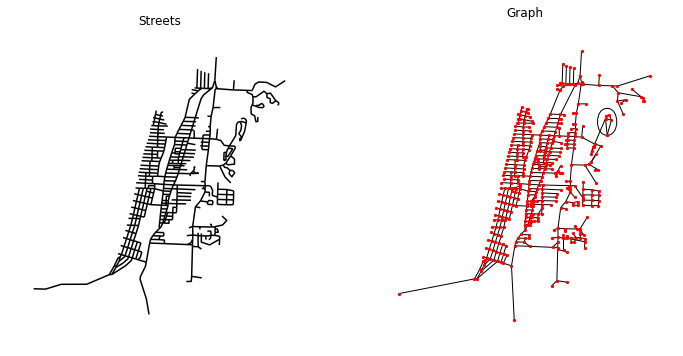

In [12]:
#Exploring the nodes and edges of the graph using NetworkX and Momepy library
# Construct the primal graph
G_primal = momepy.gdf_to_nx(seaside, approach="primal")
#pos = nx.spring_layout(G_primal1, seed= 3253337 )

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
seaside.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Graph")[i])
    facet.axis("off")

#nx.draw_networkx_labels({n: [n[0], n[1]] for n in list(G_primal1.nodes)}, pos, font_size=8, font_family='sans-serif', font_weight='light', ax=ax[1])
nx.draw(    G_primal, {n: [n[0], n[1]] for n in list(G_primal.nodes)}, ax=ax[1], node_size=5, node_color="r", with_labels=False)

100%|██████████| 438/438 [00:00<00:00, 520.60it/s]
c:\Users\Aditya Kasturi\.conda\envs\networkx\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
c:\Users\Aditya Kasturi\.conda\envs\networkx\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


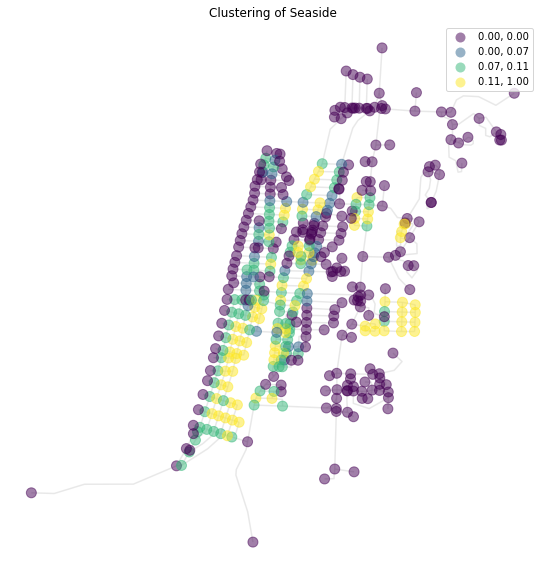

In [15]:
#Cluster the graph using Momepy library and plot the graph
graph2 = momepy.gdf_to_nx(seaside)

graph2 = momepy.clustering(graph2, name='clustering')
graph2 = momepy.meshedness(graph2, radius=5, name='meshedness')
nodes = momepy.nx_to_gdf(graph2, points=True, lines=False, spatial_weights=False)
f, ax = plt.subplots(figsize=(10, 10))
nodes.plot(ax=ax, column='clustering', markersize=100, legend=True, cmap='viridis',
           scheme='quantiles', alpha=0.5, zorder=2)
seaside.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
ax.set_title('Clustering of Seaside')


plt.show()
plt.show()
#save the file output in  a variable
seaside_graph = nx.Graph(graph2)

new_graph = momepy.nx_to_gdf(seaside_graph, points=True, lines=False, spatial_weights=False)

TypeError: 'int' object is not subscriptable

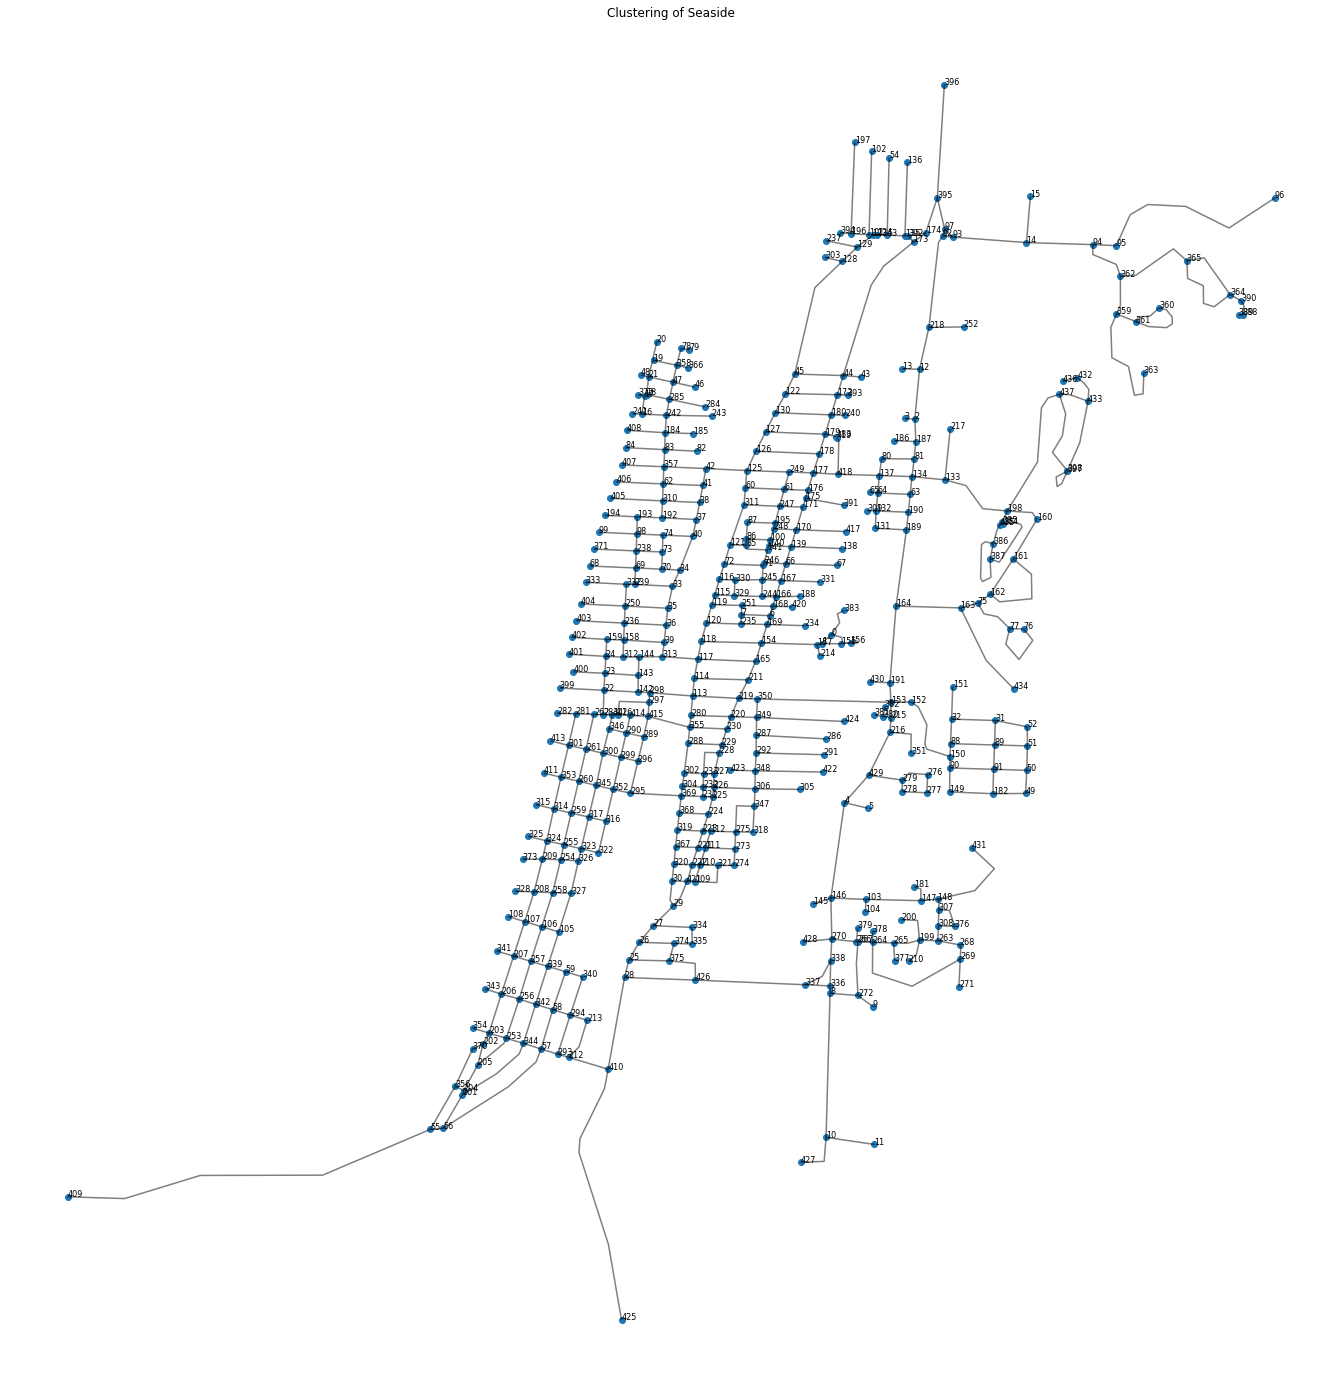

In [19]:
ax = new_graph.plot(figsize=(25, 25))

seaside.plot(ax=ax, color='black', alpha=0.5, zorder=1)
#add columns from seaside dataframe to the new graph

for x, y, label in zip(new_graph.geometry.x, new_graph.geometry.y, new_graph.index):
    ax.text(x, y, label, fontsize=8)
ax.set_axis_off()
ax.set_title('Clustering of Seaside')

positions = {n: [n[0], n[1]] for n in list(G.nodes)}
nx.draw(G, positions, ax=ax, node_size=5)
plt.show()

#assign the output to a variable
clustering_seaside = new_graph

In [27]:
#Performing Maximum Flow on the graph for Optimization using preflow_push algorithm
import networkx as nx
from networkx.algorithms.flow import preflow_push

#creating a graph object
G = nx.from_pandas_edgelist(seaside, 'Start_node', 'End_node', edge_attr=True)
n = G.number_of_nodes()
#set all the capacity to 1
for u,v in G.edges():
    G[u][v]['capacity'] = 1

print("The graph has %d nodes and %d edges" % (n, G.number_of_edges()))

#Calculating the time taken to execute the code
start = time.time()
#Performing Maximum Flow on the graph for Optimization using Shortest Agumented Path
totalFlow = 0.0 #Total flow
counter = 0 #Counter for the number of iterations
#For loop to calculate the maximum flow for all the nodes in the graph
for i in  range(1,n):
    for j in  range(1,n):
        
        
        #if the degree of i == 1 or the degree of j == 1, then make the default  maximum flow as 1
        if (G.degree(i) == 1 or G.degree(j) == 1):
            maxFlow = 1
            #print("Max Flow from %d to %d: %d" % (i, j, maxFlow))
            
        elif (i<j):
            #Calculating the maximum flow for the given pair of nodes using preflow push algorithm
            counter = counter + 1
            maxFlow = nx.maximum_flow(G, i, j, capacity='capacity', flow_func=preflow_push)
            totalFlow += maxFlow[0]

end = time.time() #Calculating the time taken to execute the code
print("Average all pairs max flow: %f" % (totalFlow/counter))
print("Total Time taken to execute this Netowrk (in seconds):", end - start) #Printing the time taken to execute the code
print("********************************************************")

The graph has 438 nodes and 583 edges
Average all pairs max flow: 2.073661
Total Time taken to execute this Netowrk (in seconds): 1358.3162915706635
********************************************************


In [25]:
#Performing Maximum Flow on the graph for Optimization using Edmonds-Karp algorithm
import networkx as nx
from networkx.algorithms.flow import edmonds_karp

#creating a graph object
G = nx.from_pandas_edgelist(seaside, 'Start_node', 'End_node', edge_attr=True)
n = G.number_of_nodes()
#set all the capacity to 1
for u,v in G.edges():
    G[u][v]['capacity'] = 1

print("The graph has %d nodes and %d edges" % (n, G.number_of_edges()))

#Calculating the time taken to execute the code
start = time.time()
print("*****************************")
#Performing Maximum Flow on the graph for Optimization using Edmonds-Karp algorithm
totalFlow = 0.0 #Total flow
counter = 0 #Counter for the number of iterations
#For loop to calculate the maximum flow for all the nodes in the graph
for i in  range(1,n):
    for j in  range(1,n):
        
        
        #if the degree of i == 1 or the degree of j == 1, then make the default  maximum flow as 1
        if (G.degree(i) == 1 or G.degree(j) == 1):
            maxFlow = 1
            #print("Max Flow from %d to %d: %d" % (i, j, maxFlow))
            
        elif (i<j):
            #Calculating the maximum flow for the given pair of nodes using preflow push algorithm
            counter = counter + 1
            maxFlow = nx.maximum_flow(G, i, j, capacity='capacity', flow_func=edmonds_karp)
            totalFlow += maxFlow[0]
    
end = time.time() #Calculating the time taken to execute the code

print("Average all pairs max flow: %f" % (totalFlow/counter))
print("Total Time taken to execute this Netowrk (in seconds):", end - start) #Printing the time taken to execute the code
print("********************************************************")

The graph has 438 nodes and 583 edges
*****************************
Average all pairs max flow: 2.073661
Total Time taken to execute this Netowrk (in seconds): 372.4928743839264
********************************************************


In [26]:
#Performing Maximum Flow on the graph for Optimization using Dinic's algorithm
import networkx as nx
from networkx.algorithms.flow import dinitz

#creating a graph object
G = nx.from_pandas_edgelist(seaside, 'Start_node', 'End_node', edge_attr=True)
n = G.number_of_nodes()
#set all the capacity to 1
for u,v in G.edges():
    G[u][v]['capacity'] = 1

print("The graph has %d nodes and %d edges" % (n, G.number_of_edges()))

#Calculating the time taken to execute the code
start = time.time()
print("*****************************")
print("All pairs Max Flow:")

totalFlow = 0.0 #Total flow
counter = 0 #Counter for the number of iterations
#For loop to calculate the maximum flow for all the nodes in the graph
for i in  range(1,n):
    for j in  range(1,n):
        
        
        #if the degree of i == 1 or the degree of j == 1, then make the default  maximum flow as 1
        if (G.degree(i) == 1 or G.degree(j) == 1):
            maxFlow = 1
            #print("Max Flow from %d to %d: %d" % (i, j, maxFlow))
            
        elif (i<j):
            
            counter = counter + 1
            maxFlow = nx.maximum_flow(G, i, j, capacity='capacity', flow_func=dinitz)
            totalFlow += maxFlow[0]
    
end = time.time() #Calculating the time taken to execute the code
print("Average all pairs max flow: %f" % (totalFlow/counter))
print("Total Time taken to execute this Netowrk (in seconds):", end - start) #Printing the time taken to execute the code
print("********************************************************")

The graph has 438 nodes and 583 edges
*****************************
All pairs Max Flow:
Average all pairs max flow: 2.073661
Total Time taken to execute this Netowrk (in seconds): 435.3566792011261
********************************************************
